<a href="https://colab.research.google.com/github/sangoncalves/applied_data_science_bootcamp/blob/main/Sander_Martins_Gon%C3%A7alves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA SICENCE BOOTCAMP - FINAL PROJECT

## 1.SCOPE

### 1.1 DESCRIPTION
Final project of "Applied Data Science" Bootcamp (Alura). This project has as objective put into practice the knowledge gathered throughout the bootcamp by analysing a dataset that resambles a real case scenario. 


---



### 1.2 OBJECTIVE

Predict which patients will need to be admitted to the intensive care unit and thus define the need for hospital ICU beds, based on the individual clinical data available.
****

### 1.3 DATA

**Main dataset (Kaggle):** [COVID-19](https://www.kaggle.com/Sírio-Libanes/covid19) (Hospital Sírio Libanês - São Paulo e Brasília - Brazil )  
<br>
This dataset contains the following variables:
1. Demographic info - 3 variables
2. Pre-existing diseases - 9 variables
3. Blood test results - 36 variables
4. Vital signs - 6 variables


---



### 1.4 MODELS TO BE ANALYSED
* Logistic Regression
* Random Forest Classifier
* SVM - Linear Kernel
* Decision Tree Classifier
* Naive Bayes
* K Neighbors Classifier


---



## 2.LIBRARIES

In [1]:
#GENERAL USE LIBRARIES
import os
import pandas as pd
import numpy as np
!pip install varname &> /dev/null #take the name of a variable
from varname import nameof
!conda install openpyxl -y &> /dev/null #used this due to some error while using the read_excel function.
import warnings
warnings.filterwarnings('ignore')

#MODELS AND SETUP (DEFINE THE PROCESSING TO BE DONE ON DATA, LIKE PCA.)
!pip install pycaret[full] &> /dev/null
from pycaret.classification import *

#STYLING
from IPython.display import HTML

## 3.FUNCTIONS

In [2]:
#PREPROCESSING AND CLEANING
def df_processing(df):
  '''
  DATA CLEANING CASES:
  * cleaning 1 - "WINDOW" 0-2 and "ICU" 1. This case represents patient that arrived at the hospital with need of using ICU, we have nothing to predict in this case.
  * cleaning 2 - "AGE_PERCENTIL" seems to be just a range to anonymize the data. We can transform this column into integer and check if it is relevant to the analysis
  * cleaning 3 - dropping 'WINDOW' since we won't be predicting the window
  * cleaning 4 - grouping patient and removing the NAN by using the mean
  * cleaning 5 - the mean will change the ICU value to *0* or a *number less than 1* (1 divided by the number of windows). So we update this number back to 1.
  '''

  #cleaning 1
  df_covid_clean = df.query("not(WINDOW == '0-2' & ICU == 1)") #Mandatory condition

  #cleaning 2
  df_covid_clean['AGE_PERCENTIL'] = np.where((df_covid_clean.AGE_PERCENTIL == 'Above 90th'),'100',df_covid_clean.AGE_PERCENTIL)
  df_covid_clean["AGE_PERCENTIL"] = df_covid_clean["AGE_PERCENTIL"].map(lambda x: x.rstrip('th')).astype("category")
  
  #cleaning 3
  df_covid_no_window = df_covid_clean.drop('WINDOW', axis =1)

  #cleaning 4
  df_covid_grouped = df_covid_no_window.groupby(by='PATIENT_VISIT_IDENTIFIER').mean()

  #cleaning 5
  df_covid_grouped.loc[df_covid_grouped.ICU>0,'ICU']=1

  return df_covid_grouped

#HIGHLITES THE HIGHEST VALUE FOR EACH COLUMN
def highlight_max(s):
  '''
  highlight the maximum in a Series yellow.
  '''
  is_max = s == s.max()
  return ['background-color: #7CFC00; color:black; font-weight:semi-bold' if v else '' for v in is_max]

#ADD HOVER EFFECT TO THE TABLE
def hover(hover_color="#A5F2F380"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])

#HIDES INDEX, CHANGES FONT SIZE AND ALIGNMENT
def df_styling(df):
  styles = [
      hover(),
      dict(selector="th", props=[("font-size", "120%"),
                                ("text-align", "center")])
  ]
  with pd.option_context('display.precision', 4):
    df_styled = (df.style.hide_index().set_table_styles(styles)).apply(highlight_max,
                subset=pd.IndexSlice[:,['Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC']])
    return df_styled

## 4.LOADING DATA AND DEFINING SETUP

In [3]:
#LOADING DATASET
df_covid = pd.read_excel('https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')

#CLEANING AND PREPROCESSING
data = df_processing(df_covid)

 **Initializing setup and setting the processing configuration:**

-> defining a seed for recomputation

-> applying pca to reduce the features (holding 95% of variability) and avoid overfitting

-> normalizing the data and substituing the NA's by the mean of the data.

-> splitting 0.7/0.3 (train/test) 

-> shuffling and splitting the data in a stratified way

-> applying 10 fold cross validation

In [4]:
settings = setup(data, target="ICU", silent= True,session_id = 141414,
                pca=True, pca_components = .95,
                normalize= True,
                train_size = 0.7, 
                data_split_shuffle=True,data_split_stratify=True,
                fold_strategy = 'stratifiedkfold',fold =10,fold_shuffle = True)
# this "settings" variable will be automatically used on the pycaret models, don't need to call this variable on the functions bellow.

,Description,Value
0,session_id,141414
1,Target,ICU
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(385, 228)"
5,Missing Values,True
6,Numeric Features,189
7,Categorical Features,38
8,Ordinal Features,False
9,High Cardinality Features,False


## 5.MODEL COMPARISON

In this section we will be comparing the possible models to be used and which one would be the best alternative for this project. This process will be divided into 4 parts:
* **Information related to blended and stacked models**
* **Training and tunning**
* **Model comparison**
* **Model selection**

After comparing all models, the one with the highest **Recall** is chosen if the other metrics are high enough. 

The criteria of recall is chosen as the main important due to the nature of our problem, which is:

 **Predicting that a person won't be needing ICU incorrectly (false negative) is perceived as worse case scenario**.


---



#### 5.1 **BLENDED MODEL**
Blended models use conjoint models for the output. The ilustration of a decision tree for a random forest suits well for explaining how a blended model works. Since the output would be the majority of the outputs of the models. 

There are two way of using the models in conjoint, **hard** or **soft**. In our case we are going to use the soft method and analysing the top models from the initial comparison list.


**‘hard’** -> uses **predicted class labels** (output of the models) for the final decision.

**‘soft’** -> predicts the class label based on the argmax (the highest value) of the sums of the **predicted probabilities**.


---



#### 5.2 **STACKED MODEL**

The idea of stacking models is to use the output of a number of models as the input of the **meta-model** (the model that is going to decide the classification). In the sense of using multiple models, stacked models are similar to blended models.


---



### 5.3 MODEL TRAINING AND COMPARISON

The following models will be using the data processed on the previous step (SETUP). Pycaret model functions automatically takes the processed data without the need of formally add as parameter.

In [5]:
#MODEL TRAINING
lr_model  = create_model('lr', verbose=False)
knn_model = create_model('knn',verbose=False)
nb_model  = create_model('nb', verbose=False)
dt_model  = create_model('dt', verbose=False)
svm_model = create_model('svm',verbose=False)
rf_model  = create_model('rf', verbose=False)

#MODEL TUNING
lr_tuned  = tune_model(lr_model, verbose=False,optimize="Recall", fold = 10)
knn_tuned = tune_model(knn_model,verbose=False,optimize="Recall", fold = 10)
nb_tuned  = tune_model(nb_model, verbose=False,optimize="Recall", fold = 10)
dt_tuned  = tune_model(dt_model, verbose=False,optimize="Recall", fold = 10)
svm_tuned = tune_model(svm_model,verbose=False,optimize="Recall", fold = 10)
rf_tuned  = tune_model(rf_model, verbose=False,optimize="Recall", fold = 10)

#CREATING BLENDED AND STACKED MODELS FROM THE TUNED MODELS
blended = blend_models( estimator_list=[lr_tuned,knn_tuned,nb_tuned,dt_tuned,svm_tuned,rf_tuned],optimize = "Recall",verbose=False) 
stacked = stack_models(estimator_list = [knn_tuned,nb_tuned,dt_tuned,svm_tuned,rf_tuned], meta_model = lr_tuned,optimize = "Recall",verbose=False)


In [6]:
#LIST OF THE MODELS ABOVE
model_list=[lr_tuned,knn_tuned,nb_tuned,dt_tuned,svm_tuned,rf_tuned,blended,stacked]

#CREATING A REPORT WITH ALL METRICS AND MODELS
df = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC']) #empty dataframe
for model in model_list:  
  y_pred = predict_model(model,verbose=False)
  arr = pull().values[0]
  data_to_append = {}
  for i in range(len(df.columns)):
    data_to_append[df.columns[i]] = arr[i]
  df = df.append(data_to_append, ignore_index = True)
df = df.sort_values(by='Recall',ascending=False)

#HIGHLIGHTING THE HIGHEST VALUE FOR EACH METRIC AND STYLING
df_styling(df)

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Decision Tree Classifier,0.5086,0.5000,1.0000,0.5086,0.6743,0.0000,0.0000
Logistic Regression,0.8966,0.9334,0.8983,0.8983,0.8983,0.7930,0.7930
SVM - Linear Kernel,0.8621,0.8617,0.8814,0.8525,0.8667,0.7239,0.7243
Random Forest Classifier,0.8707,0.9286,0.8814,0.8667,0.8739,0.7412,0.7413
Stacking Classifier,0.8879,0.9352,0.8814,0.8966,0.8889,0.7759,0.7760
Voting Classifier,0.8793,0.8799,0.8475,0.9091,0.8772,0.7588,0.7606
Naive Bayes,0.7414,0.8412,0.6441,0.8085,0.7170,0.4844,0.4951
K Neighbors Classifier,0.7672,0.8751,0.6102,0.9000,0.7273,0.5370,0.5680


### 5.4 SELECTED MODEL

As we could see, although the "*Decision Tree Classifier*" model had the highest **Recall**, the other metrics are significantly low. For that reason the chosen model is "***Logistic Regression***" for being the second best in terms of **Recall** and the best in **Accuracy** and **F1**.

In [7]:
#Parameters of the selected model
lr_tuned

LogisticRegression(C=0.772, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=141414, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
plot_model(lr_tuned, plot = 'parameter')

,Parameters
C,0.772
class_weight,{}
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,1000
multi_class,auto
n_jobs,None
penalty,l2


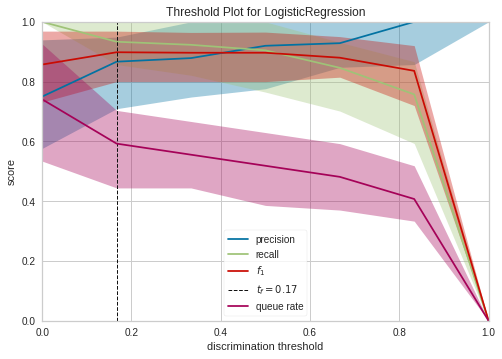

In [9]:
#we can observe here that by maximizing the recall, the model chose "0.772" as the best parameter
plot_model(lr_tuned, plot = 'threshold')

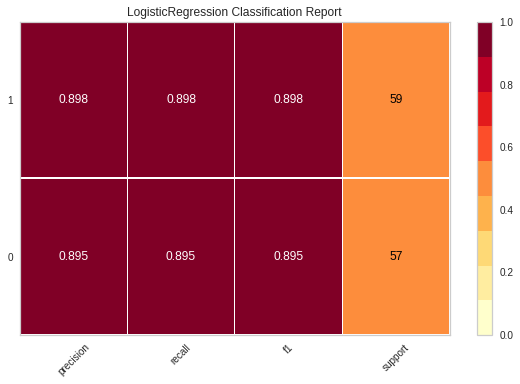

In [10]:
plot_model(lr_tuned,plot= 'class_report')

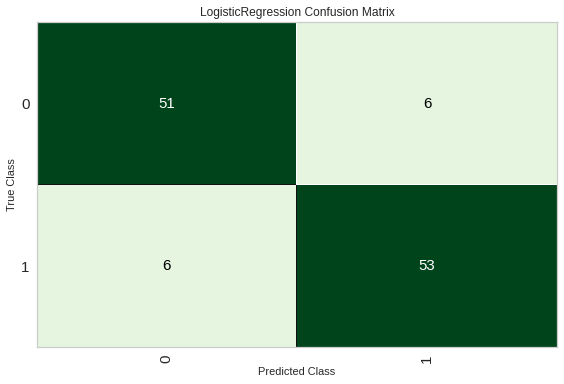

In [11]:
plot_model(lr_tuned,plot = 'confusion_matrix') 

## 6.MODEL ANALYSIS

Bellow are some plots that can help us understand how the chosen model behaves and how it seems to not be overfitting.

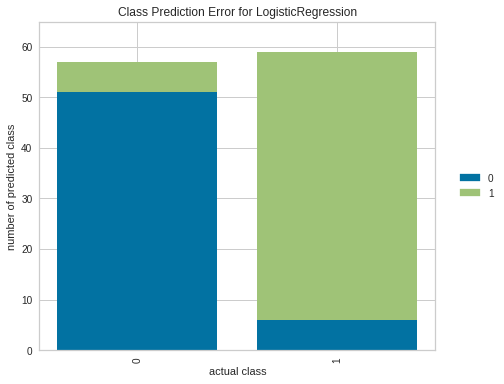

In [12]:
plot_model(lr_tuned, plot = 'error')

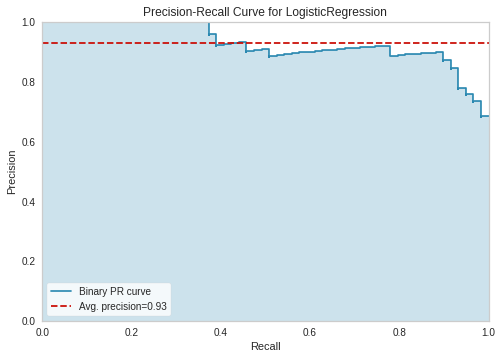

In [13]:
plot_model(lr_tuned, plot = 'pr')

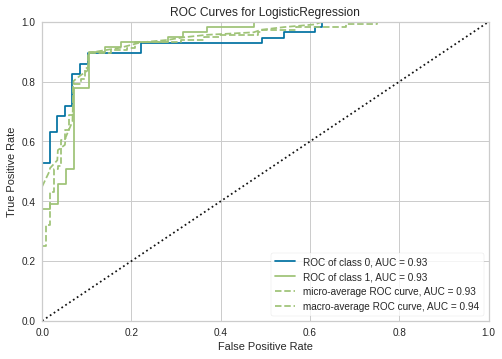

In [14]:
plot_model(lr_tuned, plot = 'auc')

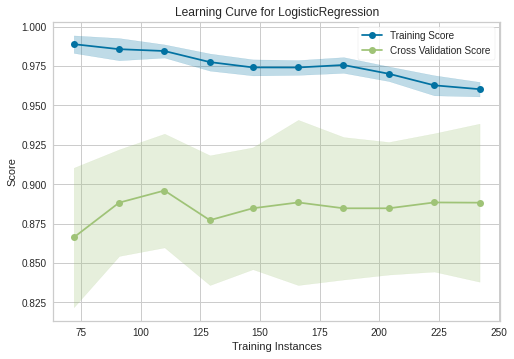

In [15]:
plot_model(lr_tuned, plot = 'learning') 

## 7.FINALIZING AND SAVING MODEL

If the given model is good enough to be used for production we can finalize it using all the data available and save it for later use.

In [16]:
#FINALIZING MODEL
final_model_ICU = finalize_model(lr_tuned)
final_model_metrics = pull()
#SAVING MODEL
save_model(final_model_ICU, 'lr_model_ICU')

#LOADING MODEL
lr_model_ICU = load_model('lr_model_ICU')

Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Successfully Loaded


In [17]:
#This is the model trained using all the data (train and test). The Idea is that the model was validated and is ready to be put into production.
final_model_metrics

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8879,0.9352,0.8814,0.8966,0.8889,0.7759,0.776


## 8.CONCLUSION

The metrics of recall and precision seems to be satisfatory, since we tried to avoid overfitting by reducing the number of features used (PCA 95% of variability). However, we need to take in consideration that our problem deals with human lives and this model do not achieve 0% erro. This mean that in we could be putting some life in danger if the output of the model is the only factor to be analysed.

This model certainly can be used to enhance the decision making but **this decision cannot be made by using solely the model!**. This model should be used as one of factor out of many to be taken in consideration.